In [3]:
import os

folder_path = "/Users/ramonjr.comendador/cs198-protein-folding/datasets"

csv_files = [f for f in os.listdir(folder_path) if (f.endswith('.csv') and not f.endswith('5.csv'))][:]

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [5]:
# FUNCTION FOR INTERPOLATING MATRIX

def interpolate_matrix(matrix, scale_factor):
    interpolated_matrix = scipy.ndimage.zoom(matrix, zoom=scale_factor, order=3)  # cubic interpolation (order=3)
    
    return interpolated_matrix

In [6]:
# CONVERT CSV TO MATRICES

def csv_to_3D_matrix(folder_path, csv_files):
    """
    Converts a list of CSV files into a 3D matrix where each CSV contributes
    a 2D matrix of values based on the 'x', 'y', and 'Value' columns.
    
    Parameters:
    - folder_path (str): The folder where the CSV files are located.
    - csv_files (list): A list of CSV file names to process.
    
    Returns:
    - list: A list of 2D matrices, each corresponding to a CSV file.
    """
    csv_to_3Dmatrix = []

    for csv_file in csv_files:
        # Load the CSV file
        energy_levels = pd.read_csv(os.path.join(folder_path, csv_file), header=None, names=['x', 'y', 'Value'])

        # Get unique x and y values
        unique_x = energy_levels['x'].unique()
        unique_y = energy_levels['y'].unique()

        # Create index mappings for x and y values
        x_index = {val: idx for idx, val in enumerate(unique_x)}
        y_index = {val: idx for idx, val in enumerate(unique_y)}

        # Initialize a matrix filled with NaNs
        matrix = np.full((len(unique_y), len(unique_x)), np.nan)

        # Fill the matrix with values from the CSV
        for _, row in energy_levels.iterrows():
            x_pos = x_index[row['x']]
            y_pos = y_index[row['y']]
            matrix[y_pos, x_pos] = row['Value']

        # Interpolate the matrix by scale factor of 10
        interpolated_matrix = interpolate_matrix(matrix=matrix, scale_factor=10)

        # print("Matrix shape: ", matrix.shape)
        # print("Interpolated Matrix shape: ", interpolated_matrix.shape)

        # Append the matrix to the list
        # csv_to_3Dmatrix.append(matrix)
        csv_to_3Dmatrix.append(interpolated_matrix)
    
    return csv_to_3Dmatrix


In [7]:
# LOCATING LOCAL MINIMA FUNCTION

def find_local_minima(matrix):
    rows, cols = matrix.shape
    local_minima = []

    def get_neighbors(x, y):
        """Get the 8 neighbors of a point (x, y) with wrap-around."""
        neighbors = []
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                # Apply wrap-around using modulo operator
                nx = (x + dx) % rows
                ny = (y + dy) % cols
                neighbors.append((nx, ny))
        return neighbors

    def is_local_minimum(x, y):
        """Check if (x, y) is a local minimum considering its neighbors."""
        value = matrix[x, y]
        neighbors = get_neighbors(x, y)
        for nx, ny in neighbors:
            if matrix[nx, ny] < value:
                return False
        return True

    def get_flat_region(x, y, visited):
        """Get all points in the flat region starting from (x, y)."""
        flat_points = [(x, y)]
        visited.add((x, y))
        value = matrix[x, y]
        stack = [(x, y)]
        while stack:
            cx, cy = stack.pop()
            neighbors = get_neighbors(cx, cy)
            for nx, ny in neighbors:
                if (nx, ny) not in visited and matrix[nx, ny] == value:
                    visited.add((nx, ny))
                    flat_points.append((nx, ny))
                    stack.append((nx, ny))
        return flat_points

    visited = set()

    for x in range(rows):
        for y in range(cols):
            if (x, y) in visited:
                continue
            
            if is_local_minimum(x, y):
                flat_region = get_flat_region(x, y, visited)
                if len(flat_region) > 1:
                    # Find the middle point of the flat region
                    flat_region = np.array(flat_region)
                    mid_idx = len(flat_region) // 2
                    middle_point = tuple(flat_region[mid_idx])
                    local_minima.append(middle_point)
                else:
                    local_minima.append((x, y))

    return local_minima

# Example usage with a random matrix
# local_minima = find_local_minima()
# print("Local minima:", local_minima)


In [8]:
# LOCATING LOCAL MAXIMA FUNCTION

def find_local_maxima(matrix):
    rows, cols = matrix.shape
    local_minima = []

    def get_neighbors(x, y):
        """Get the 8 neighbors of a point (x, y) with wrap-around."""
        neighbors = []
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                # Apply wrap-around using modulo operator
                nx = (x + dx) % rows
                ny = (y + dy) % cols
                neighbors.append((nx, ny))
        return neighbors

    def is_local_maximum(x, y):
        """Check if (x, y) is a local maximum considering its neighbors."""
        value = matrix[x, y]
        neighbors = get_neighbors(x, y)
        for nx, ny in neighbors:
            if matrix[nx, ny] > value:
                return False
        return True

    def get_flat_region(x, y, visited):
        """Get all points in the flat region starting from (x, y)."""
        flat_points = [(x, y)]
        visited.add((x, y))
        value = matrix[x, y]
        stack = [(x, y)]
        while stack:
            cx, cy = stack.pop()
            neighbors = get_neighbors(cx, cy)
            for nx, ny in neighbors:
                if (nx, ny) not in visited and matrix[nx, ny] == value:
                    visited.add((nx, ny))
                    flat_points.append((nx, ny))
                    stack.append((nx, ny))
        return flat_points

    visited = set()

    for x in range(rows):
        for y in range(cols):
            if (x, y) in visited:
                continue
            
            if is_local_maximum(x, y):
                flat_region = get_flat_region(x, y, visited)
                if len(flat_region) > 1:
                    # Find the middle point of the flat region
                    flat_region = np.array(flat_region)
                    mid_idx = len(flat_region) // 2
                    middle_point = tuple(flat_region[mid_idx])
                    local_minima.append(middle_point)
                else:
                    local_minima.append((x, y))

    return local_minima

# Example usage with a random matrix
# local_minima = find_local_minima()
# print("Local minima:", local_minima)


In [9]:
import heapq
import math

# A* with wrap-around on a 3D surface (NxN matrix) with heights
def a_star_wrap_around_surface(surface, start, goal):
    rows, cols = len(surface), len(surface[0])
    
    # Directions: Up, Down, Left, Right, and 4 Diagonals
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), 
                  (-1, -1), (-1, 1), (1, -1), (1, 1)]  # Including diagonals

    def get_neighbors(node):
        x, y = node
        neighbors = []
        for dx, dy in directions:
            nx, ny = (x + dx) % rows, (y + dy) % cols  # Wrap-around using modulo
            neighbors.append((nx, ny))
        return neighbors

    def heuristic(node1, node2):
        x1, y1 = node1
        x2, y2 = node2
        h1 = surface[x1][y1]
        h2 = surface[x2][y2]
        # Wrap-around Euclidean distance heuristic, considering height
        dx = min(abs(x1 - x2), rows - abs(x1 - x2))
        dy = min(abs(y1 - y2), cols - abs(y1 - y2))
        dz = abs(h1 - h2)
        return math.sqrt(dx ** 2 + dy ** 2 + dz ** 2)

    def distance(current, neighbor):
        # Euclidean distance between two points, considering height difference
        x1, y1 = current
        x2, y2 = neighbor
        dx = min(abs(x1 - x2), rows - abs(x1 - x2))
        dy = min(abs(y1 - y2), cols - abs(y1 - y2))
        dz = abs(surface[x1][y1] - surface[x2][y2])
        return math.sqrt(dx ** 2 + dy ** 2 + dz ** 2)

    open_list = []
    heapq.heappush(open_list, (0, start))  # Priority queue (f-cost, node)
    came_from = {}
    g_score = {start: 0}
    
    while open_list:
        _, current = heapq.heappop(open_list)
        
        if current == goal:
            # Reconstruct the path
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.reverse()
            print("Total distance:", g_score[goal])
            return path
        
        for neighbor in get_neighbors(current):
            tentative_g_score = g_score[current] + distance(current, neighbor)
            
            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score = tentative_g_score + heuristic(neighbor, goal)
                heapq.heappush(open_list, (f_score, neighbor))
    
    return None  # Return None if no path is found

# Example usage:
# A 5x5 grid where each value represents a height (z-coordinate) of a 3D surface
surface = [
    [1, 2, 3, 4, 5],
    [5, 4, 3, 2, 1],
    [1, 2, 3, 4, 5],
    [5, 4, 3, 2, 1],
    [1, 2, 3, 4, 5]
]
start = (0, 0)
goal = (4, 4)
path = a_star_wrap_around_surface(surface, start, goal)
print("Path found:", path)


Total distance: 4.242640687119285
Path found: [(4, 4)]


Total distance: 63.4852817535278
Start:  (85, 176)
Goal:  (146, 170)
Path:  [(86, 176), (87, 176), (88, 176), (89, 176), (90, 176), (91, 176), (92, 176), (93, 176), (94, 176), (95, 176), (96, 176), (97, 176), (98, 176), (99, 176), (100, 176), (101, 176), (102, 176), (103, 176), (104, 176), (105, 176), (106, 176), (107, 176), (108, 176), (109, 176), (110, 176), (111, 176), (112, 176), (113, 176), (114, 176), (115, 175), (116, 174), (117, 173), (118, 172), (119, 172), (120, 172), (121, 172), (122, 172), (123, 172), (124, 172), (125, 172), (126, 172), (127, 172), (128, 172), (129, 172), (130, 172), (131, 172), (132, 172), (133, 172), (134, 172), (135, 172), (136, 172), (137, 172), (138, 172), (139, 172), (140, 172), (141, 172), (142, 172), (143, 171), (144, 170), (145, 170), (146, 170)]
Local Minima:  (0, 15)
Local Minima:  (85, 176)
Local Minima:  (100, 0)
Local Minima:  (140, 36)
Local Minima:  (146, 170)
Local Minima:  (149, 249)
Local Minima:  (175, 67)
Local Minima:  (236, 249)
Local

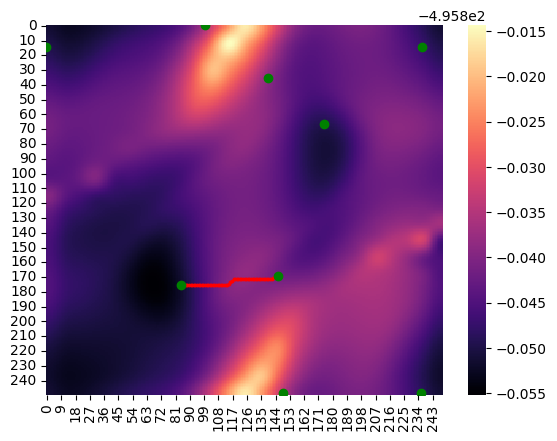

Total distance: 100.00000559090395
Start:  (0, 249)
Goal:  (150, 249)
Path:  [(249, 249), (248, 249), (247, 249), (246, 249), (245, 249), (244, 249), (243, 249), (242, 249), (241, 249), (240, 249), (239, 249), (238, 249), (237, 249), (236, 249), (235, 249), (234, 249), (233, 249), (232, 249), (231, 249), (230, 249), (229, 249), (228, 249), (227, 249), (226, 249), (225, 249), (224, 249), (223, 249), (222, 249), (221, 249), (220, 249), (219, 249), (218, 249), (217, 249), (216, 249), (215, 249), (214, 249), (213, 249), (212, 249), (211, 249), (210, 249), (209, 249), (208, 249), (207, 249), (206, 249), (205, 249), (204, 249), (203, 249), (202, 249), (201, 249), (200, 249), (199, 249), (198, 249), (197, 249), (196, 249), (195, 249), (194, 249), (193, 249), (192, 249), (191, 249), (190, 249), (189, 249), (188, 249), (187, 249), (186, 249), (185, 249), (184, 249), (183, 249), (182, 249), (181, 249), (180, 249), (179, 249), (178, 249), (177, 249), (176, 249), (175, 249), (174, 249), (173, 249)

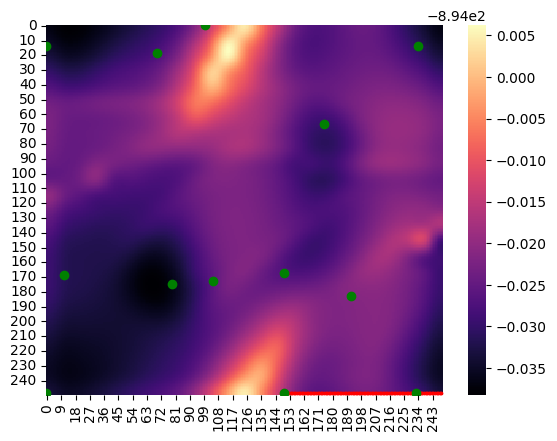

Total distance: 153.2498012669482
Start:  (0, 171)
Goal:  (148, 32)
Path:  [(249, 172), (249, 173), (249, 174), (249, 175), (248, 176), (247, 177), (246, 178), (245, 179), (244, 180), (243, 181), (242, 182), (241, 183), (240, 184), (239, 185), (238, 186), (237, 187), (236, 188), (235, 189), (234, 190), (234, 191), (234, 192), (234, 193), (234, 194), (234, 195), (234, 196), (233, 197), (232, 198), (231, 199), (230, 200), (229, 201), (228, 202), (227, 203), (226, 204), (225, 205), (224, 206), (223, 207), (222, 208), (221, 209), (220, 210), (219, 211), (218, 212), (217, 213), (216, 214), (215, 215), (214, 216), (213, 217), (212, 218), (211, 219), (210, 220), (209, 221), (208, 222), (207, 223), (206, 224), (205, 225), (204, 226), (203, 227), (202, 228), (201, 229), (200, 230), (199, 231), (198, 232), (197, 233), (196, 234), (195, 235), (194, 236), (193, 237), (192, 238), (191, 239), (190, 240), (189, 241), (188, 242), (187, 243), (186, 244), (185, 245), (184, 246), (183, 247), (182, 248), 

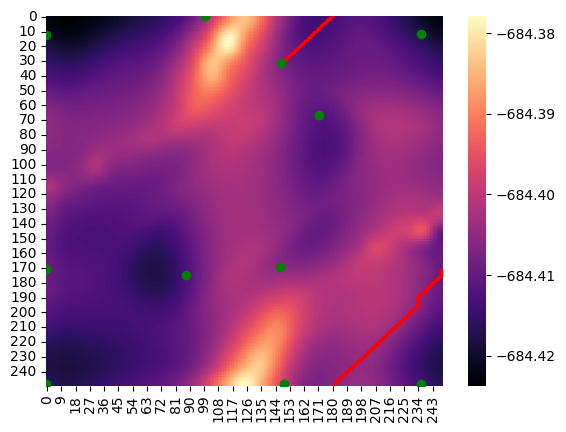

Total distance: 134.13708858418357
Start:  (0, 249)
Goal:  (149, 169)
Path:  [(249, 248), (248, 247), (247, 246), (246, 245), (245, 244), (244, 243), (243, 242), (242, 241), (241, 240), (240, 239), (239, 238), (238, 237), (237, 236), (236, 235), (235, 234), (234, 233), (233, 232), (232, 231), (231, 230), (230, 229), (229, 228), (228, 227), (227, 226), (226, 225), (225, 224), (224, 223), (223, 222), (222, 221), (221, 220), (220, 219), (219, 218), (218, 217), (217, 216), (216, 215), (215, 214), (214, 213), (213, 212), (212, 211), (211, 210), (210, 209), (209, 208), (208, 207), (207, 206), (206, 205), (205, 204), (204, 203), (203, 202), (202, 201), (201, 200), (200, 199), (199, 198), (198, 197), (197, 196), (196, 195), (195, 194), (194, 193), (193, 192), (192, 191), (191, 190), (190, 189), (189, 188), (188, 187), (187, 186), (186, 185), (185, 184), (184, 183), (183, 182), (182, 181), (181, 180), (180, 179), (179, 178), (178, 177), (177, 177), (176, 177), (175, 177), (174, 177), (173, 177)

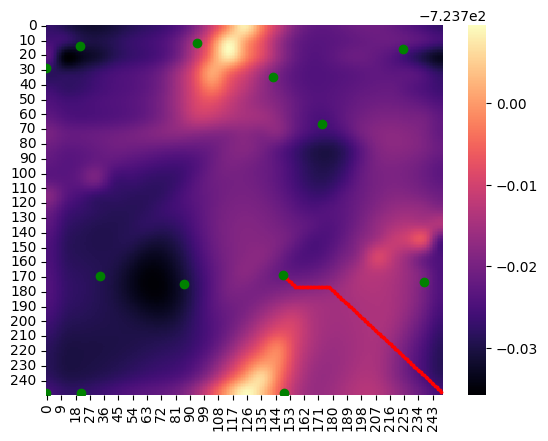

Total distance: 139.65180716083808
Start:  (0, 249)
Goal:  (141, 175)
Path:  [(249, 248), (248, 247), (247, 246), (246, 245), (245, 244), (244, 243), (243, 242), (242, 241), (241, 240), (240, 239), (239, 238), (238, 237), (237, 236), (236, 235), (235, 234), (234, 233), (233, 232), (232, 231), (231, 230), (230, 229), (229, 228), (228, 227), (227, 226), (226, 225), (225, 224), (224, 223), (223, 222), (222, 221), (221, 220), (220, 219), (219, 219), (218, 218), (217, 217), (216, 216), (215, 215), (214, 214), (213, 213), (212, 212), (211, 211), (210, 210), (209, 209), (208, 208), (207, 207), (206, 206), (205, 205), (204, 204), (203, 203), (202, 202), (201, 201), (200, 200), (199, 199), (198, 198), (197, 197), (196, 196), (195, 195), (194, 194), (193, 193), (192, 192), (191, 191), (190, 190), (189, 189), (188, 188), (187, 187), (186, 186), (185, 185), (184, 184), (183, 183), (182, 182), (181, 181), (180, 180), (179, 179), (178, 178), (177, 177), (176, 176), (175, 176), (174, 176), (173, 176)

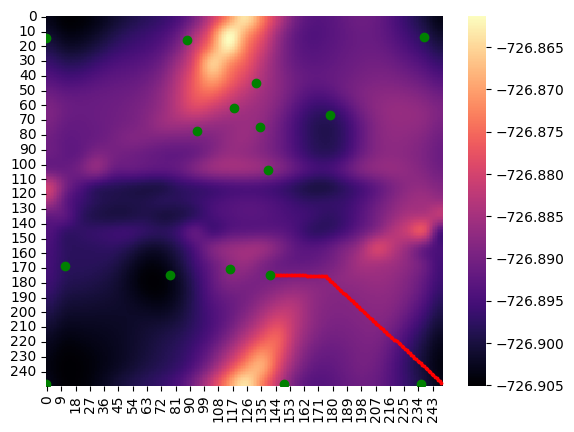

Total distance: 78.35533972273463
Start:  (75, 182)
Goal:  (100, 0)
Path:  [(75, 183), (75, 184), (75, 185), (75, 186), (75, 187), (75, 188), (75, 189), (75, 190), (76, 191), (77, 192), (78, 193), (79, 194), (80, 195), (81, 196), (82, 197), (83, 198), (84, 199), (85, 200), (86, 201), (87, 202), (88, 203), (89, 204), (90, 205), (90, 206), (90, 207), (90, 208), (90, 209), (90, 210), (90, 211), (90, 212), (90, 213), (90, 214), (90, 215), (90, 216), (90, 217), (90, 218), (90, 219), (90, 220), (90, 221), (90, 222), (90, 223), (90, 224), (90, 225), (90, 226), (90, 227), (90, 228), (90, 229), (90, 230), (90, 231), (90, 232), (90, 233), (90, 234), (90, 235), (90, 236), (90, 237), (91, 238), (92, 239), (93, 240), (94, 241), (95, 242), (96, 243), (97, 244), (98, 245), (99, 246), (99, 247), (99, 248), (99, 249), (100, 0)]
Local Minima:  (0, 0)
Local Minima:  (75, 182)
Local Minima:  (100, 0)
Local Minima:  (109, 210)
Local Minima:  (140, 39)
Local Minima:  (149, 249)
Local Minima:  (172, 68)


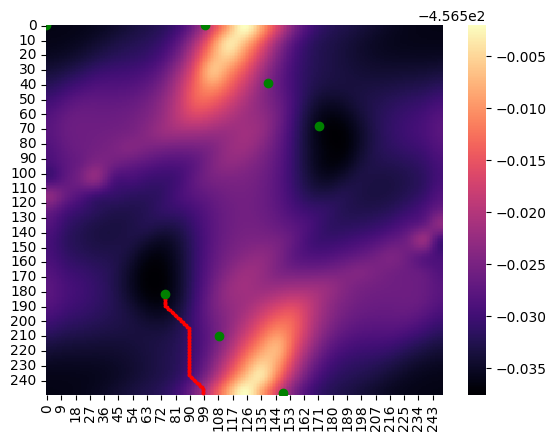

Total distance: 107.38477839565202
Start:  (2, 12)
Goal:  (150, 249)
Path:  [(1, 12), (0, 12), (249, 12), (248, 12), (247, 12), (246, 12), (245, 12), (244, 12), (243, 12), (242, 12), (241, 12), (240, 12), (239, 12), (238, 12), (237, 12), (236, 12), (235, 12), (234, 12), (233, 12), (232, 12), (231, 12), (230, 12), (229, 12), (228, 12), (227, 12), (226, 12), (225, 12), (224, 12), (223, 12), (222, 12), (221, 12), (220, 12), (219, 12), (218, 12), (217, 12), (216, 12), (215, 12), (214, 12), (213, 12), (212, 12), (211, 12), (210, 12), (209, 12), (208, 12), (207, 12), (206, 12), (205, 12), (204, 12), (203, 12), (202, 12), (201, 12), (200, 12), (199, 12), (198, 12), (197, 12), (196, 12), (195, 12), (194, 12), (193, 12), (192, 12), (191, 12), (190, 12), (189, 12), (188, 12), (187, 12), (186, 12), (185, 12), (184, 12), (183, 12), (182, 12), (181, 12), (180, 12), (179, 12), (178, 12), (177, 12), (176, 12), (175, 12), (174, 12), (173, 12), (172, 12), (171, 12), (170, 12), (169, 11), (168, 10), (16

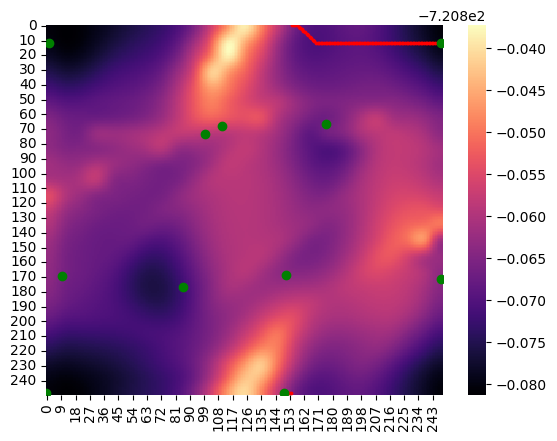

Total distance: 130.0243868548403
Start:  (98, 14)
Goal:  (156, 158)
Path:  [(99, 13), (100, 12), (101, 11), (102, 10), (103, 9), (103, 8), (103, 7), (103, 6), (103, 5), (103, 4), (103, 3), (103, 2), (103, 1), (103, 0), (104, 249), (105, 248), (106, 247), (107, 246), (107, 245), (107, 244), (107, 243), (107, 242), (107, 241), (107, 240), (107, 239), (107, 238), (107, 237), (107, 236), (107, 235), (107, 234), (107, 233), (107, 232), (107, 231), (107, 230), (107, 229), (107, 228), (107, 227), (107, 226), (107, 225), (107, 224), (107, 223), (107, 222), (107, 221), (107, 220), (108, 219), (108, 218), (108, 217), (108, 216), (108, 215), (108, 214), (108, 213), (108, 212), (108, 211), (108, 210), (108, 209), (108, 208), (108, 207), (108, 206), (109, 205), (110, 204), (111, 203), (112, 202), (113, 201), (114, 200), (115, 199), (116, 198), (117, 197), (118, 196), (119, 195), (120, 194), (121, 193), (122, 192), (123, 191), (124, 190), (125, 189), (126, 188), (127, 187), (128, 186), (129, 185), 

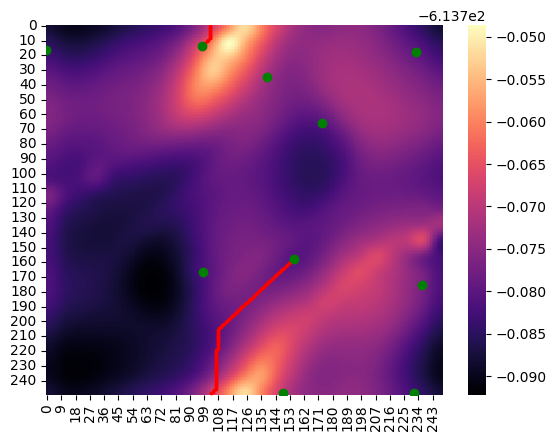

Total distance: 134.5513007584377
Start:  (0, 0)
Goal:  (149, 169)
Path:  [(249, 249), (248, 248), (247, 247), (246, 246), (245, 245), (244, 244), (243, 243), (242, 242), (241, 241), (240, 240), (239, 239), (238, 238), (237, 237), (236, 236), (235, 235), (234, 234), (233, 233), (232, 232), (231, 231), (230, 230), (229, 229), (228, 228), (227, 227), (226, 226), (225, 225), (224, 224), (223, 223), (222, 222), (221, 221), (220, 220), (219, 219), (218, 218), (217, 217), (216, 216), (215, 215), (214, 214), (213, 213), (212, 212), (211, 211), (210, 210), (209, 209), (208, 208), (207, 207), (206, 206), (205, 205), (204, 204), (203, 203), (202, 202), (201, 201), (200, 200), (199, 199), (198, 198), (197, 197), (196, 196), (195, 195), (194, 194), (193, 193), (192, 192), (191, 191), (190, 190), (189, 189), (188, 188), (187, 187), (186, 186), (185, 185), (184, 184), (183, 183), (182, 182), (181, 181), (180, 180), (179, 179), (178, 178), (177, 177), (176, 177), (175, 177), (174, 177), (173, 177), (

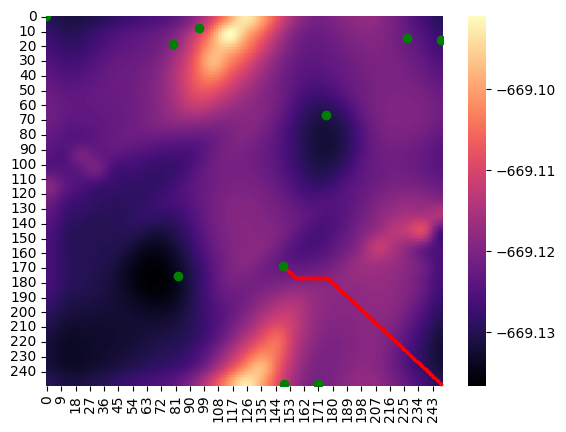

Total distance: 101.75230937350096
Start:  (0, 0)
Goal:  (176, 67)
Path:  [(249, 1), (248, 2), (247, 3), (246, 4), (245, 5), (244, 6), (243, 7), (242, 8), (241, 9), (240, 10), (239, 11), (238, 12), (237, 13), (236, 14), (235, 15), (234, 16), (233, 17), (232, 18), (231, 19), (230, 20), (229, 21), (228, 22), (227, 23), (226, 24), (225, 25), (224, 26), (223, 27), (222, 28), (221, 29), (220, 30), (219, 31), (218, 32), (217, 33), (216, 34), (215, 35), (214, 36), (213, 37), (212, 38), (211, 39), (210, 40), (209, 41), (208, 42), (207, 43), (206, 44), (205, 45), (204, 46), (203, 47), (202, 48), (201, 49), (200, 50), (199, 51), (198, 52), (197, 53), (196, 54), (195, 55), (194, 56), (193, 57), (192, 58), (191, 59), (190, 59), (189, 59), (188, 59), (187, 59), (186, 59), (185, 59), (184, 59), (183, 60), (182, 61), (181, 62), (180, 63), (179, 64), (178, 65), (177, 66), (176, 67)]
Local Minima:  (0, 48)
Local Minima:  (0, 0)
Local Minima:  (85, 175)
Local Minima:  (93, 13)
Local Minima:  (111, 66)
L

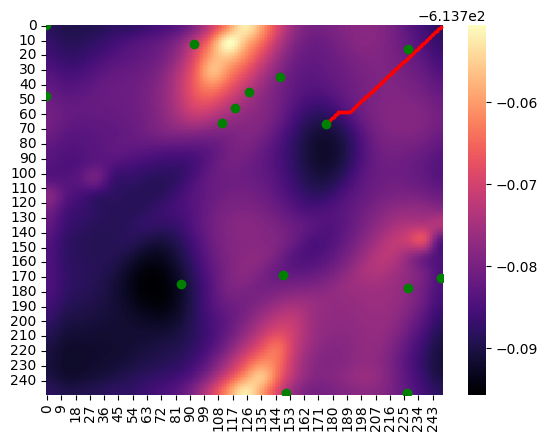

Total distance: 100.28427175728535
Start:  (10, 229)
Goal:  (168, 249)
Path:  [(9, 230), (8, 230), (7, 231), (6, 232), (5, 233), (4, 233), (3, 233), (2, 233), (1, 233), (0, 233), (249, 233), (248, 233), (247, 233), (246, 234), (245, 235), (244, 236), (243, 236), (242, 236), (241, 236), (240, 236), (239, 236), (238, 236), (237, 236), (236, 236), (235, 236), (234, 236), (233, 236), (232, 236), (231, 236), (230, 236), (229, 236), (228, 236), (227, 236), (226, 236), (225, 236), (224, 236), (223, 236), (222, 236), (221, 236), (220, 236), (219, 236), (218, 236), (217, 236), (216, 236), (215, 236), (214, 236), (213, 236), (212, 236), (211, 236), (210, 236), (209, 237), (208, 238), (207, 239), (206, 240), (205, 241), (204, 242), (203, 243), (202, 244), (201, 245), (200, 246), (199, 247), (198, 248), (197, 249), (196, 249), (195, 249), (194, 249), (193, 249), (192, 249), (191, 249), (190, 249), (189, 249), (188, 249), (187, 249), (186, 249), (185, 249), (184, 249), (183, 249), (182, 249), (181,

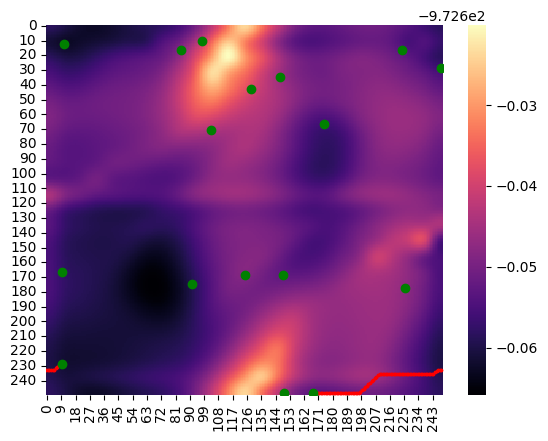

Total distance: 90.97056501093459
Start:  (4, 11)
Goal:  (168, 249)
Path:  [(3, 11), (2, 11), (1, 11), (0, 11), (249, 11), (248, 11), (247, 11), (246, 11), (245, 11), (244, 11), (243, 11), (242, 11), (241, 11), (240, 11), (239, 11), (238, 11), (237, 11), (236, 11), (235, 11), (234, 10), (233, 9), (232, 8), (231, 7), (230, 6), (229, 5), (228, 5), (227, 5), (226, 5), (225, 5), (224, 5), (223, 5), (222, 5), (221, 5), (220, 5), (219, 5), (218, 5), (217, 5), (216, 5), (215, 5), (214, 5), (213, 5), (212, 4), (211, 3), (210, 2), (209, 1), (208, 0), (207, 249), (206, 249), (205, 249), (204, 249), (203, 249), (202, 249), (201, 249), (200, 249), (199, 249), (198, 249), (197, 249), (196, 249), (195, 249), (194, 249), (193, 249), (192, 249), (191, 249), (190, 249), (189, 249), (188, 249), (187, 249), (186, 249), (185, 249), (184, 249), (183, 249), (182, 249), (181, 249), (180, 249), (179, 249), (178, 249), (177, 249), (176, 249), (175, 249), (174, 249), (173, 249), (172, 249), (171, 249), (170, 24

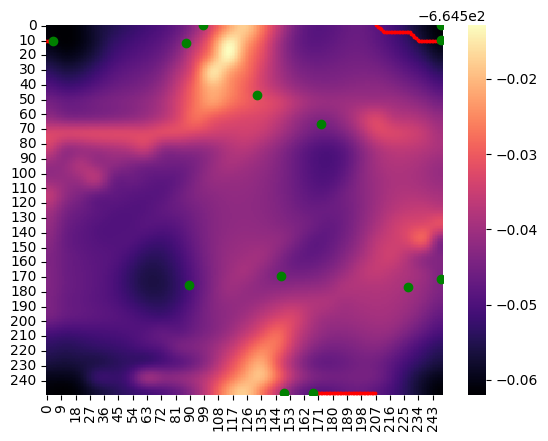

Total distance: 102.41421661575384
Start:  (0, 0)
Goal:  (148, 249)
Path:  [(249, 0), (248, 0), (247, 0), (246, 0), (245, 0), (244, 0), (243, 0), (242, 0), (241, 0), (240, 0), (239, 0), (238, 0), (237, 0), (236, 0), (235, 0), (234, 0), (233, 0), (232, 0), (231, 0), (230, 0), (229, 0), (228, 0), (227, 0), (226, 0), (225, 0), (224, 0), (223, 0), (222, 0), (221, 0), (220, 0), (219, 0), (218, 0), (217, 0), (216, 0), (215, 0), (214, 0), (213, 0), (212, 0), (211, 0), (210, 0), (209, 0), (208, 0), (207, 0), (206, 0), (205, 0), (204, 0), (203, 0), (202, 0), (201, 249), (200, 249), (199, 249), (198, 249), (197, 249), (196, 249), (195, 249), (194, 249), (193, 249), (192, 249), (191, 249), (190, 249), (189, 249), (188, 249), (187, 249), (186, 249), (185, 249), (184, 249), (183, 249), (182, 249), (181, 249), (180, 249), (179, 249), (178, 249), (177, 249), (176, 249), (175, 249), (174, 249), (173, 249), (172, 249), (171, 249), (170, 249), (169, 249), (168, 249), (167, 249), (166, 249), (165, 249), 

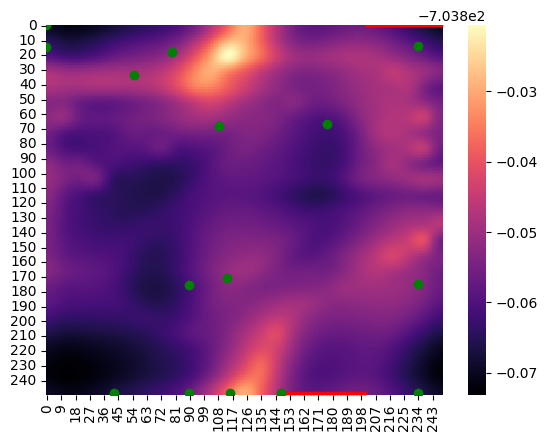

Total distance: 78.2842718339715
Start:  (80, 19)
Goal:  (150, 249)
Path:  [(81, 18), (82, 17), (83, 16), (84, 15), (85, 14), (86, 13), (87, 13), (88, 13), (89, 13), (90, 13), (91, 13), (92, 13), (93, 13), (94, 13), (95, 13), (96, 13), (97, 13), (98, 13), (99, 13), (100, 13), (101, 13), (102, 13), (103, 13), (104, 13), (105, 13), (106, 13), (107, 13), (108, 13), (109, 13), (110, 13), (111, 13), (112, 13), (113, 13), (114, 13), (115, 13), (116, 13), (117, 13), (118, 13), (119, 12), (120, 11), (121, 10), (122, 9), (123, 8), (124, 7), (125, 6), (126, 5), (127, 4), (128, 3), (129, 2), (130, 1), (131, 0), (132, 0), (133, 0), (134, 0), (135, 0), (136, 0), (137, 0), (138, 0), (139, 0), (140, 0), (141, 0), (142, 0), (143, 0), (144, 0), (145, 0), (146, 249), (147, 249), (148, 249), (149, 249), (150, 249)]
Local Minima:  (0, 0)
Local Minima:  (80, 19)
Local Minima:  (85, 175)
Local Minima:  (96, 8)
Local Minima:  (146, 36)
Local Minima:  (149, 169)
Local Minima:  (150, 249)
Local Minima:  (169, 

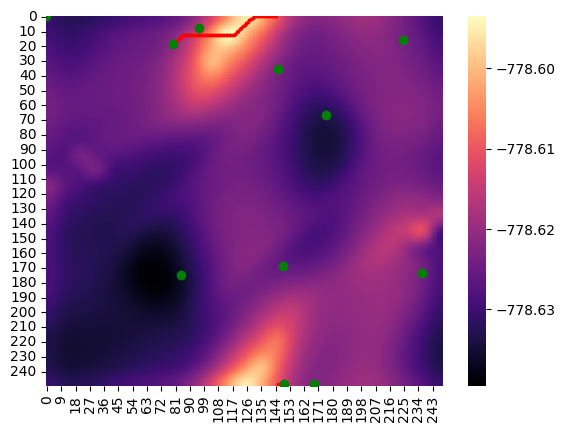

Total distance: 148.76450829312853
Start:  (5, 15)
Goal:  (146, 169)
Path:  [(4, 14), (3, 13), (2, 12), (1, 11), (0, 10), (249, 9), (248, 8), (247, 7), (246, 6), (245, 5), (244, 4), (243, 3), (242, 2), (241, 2), (240, 1), (239, 0), (238, 249), (237, 249), (236, 249), (235, 249), (234, 249), (233, 249), (232, 248), (231, 247), (230, 246), (229, 246), (228, 246), (227, 246), (226, 246), (225, 246), (224, 246), (223, 246), (222, 245), (221, 244), (220, 243), (219, 242), (218, 241), (217, 240), (216, 239), (215, 238), (214, 237), (213, 236), (212, 235), (211, 234), (210, 233), (209, 232), (208, 231), (207, 230), (206, 229), (205, 228), (204, 227), (203, 226), (202, 225), (201, 224), (200, 223), (199, 222), (198, 221), (197, 220), (196, 219), (195, 218), (194, 217), (193, 216), (192, 215), (191, 214), (190, 213), (189, 212), (188, 211), (187, 210), (186, 209), (185, 208), (184, 207), (183, 206), (182, 205), (181, 204), (180, 203), (179, 202), (178, 201), (177, 200), (176, 199), (175, 198), 

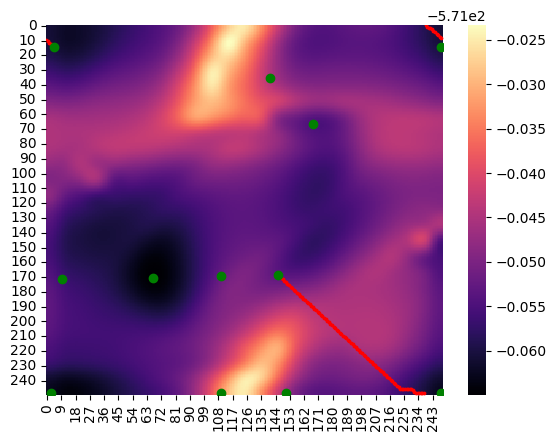

Total distance: 116.41421839313107
Start:  (0, 0)
Goal:  (116, 249)
Path:  [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (33, 0), (34, 0), (35, 0), (36, 0), (37, 0), (38, 0), (39, 0), (40, 0), (41, 0), (42, 0), (43, 0), (44, 0), (45, 0), (46, 0), (47, 0), (48, 0), (49, 0), (50, 0), (51, 0), (52, 0), (53, 0), (54, 0), (55, 0), (56, 0), (57, 0), (58, 0), (59, 0), (60, 0), (61, 0), (62, 0), (63, 0), (64, 0), (65, 0), (66, 0), (67, 0), (68, 0), (69, 0), (70, 0), (71, 0), (72, 0), (73, 0), (74, 0), (75, 0), (76, 0), (77, 0), (78, 0), (79, 0), (80, 0), (81, 0), (82, 0), (83, 0), (84, 0), (85, 0), (86, 0), (87, 0), (88, 0), (89, 0), (90, 0), (91, 0), (92, 0), (93, 0), (94, 0), (95, 249), (96, 249), (97, 249), (98, 249), (99, 249), (100, 249), (101, 249), (102, 24

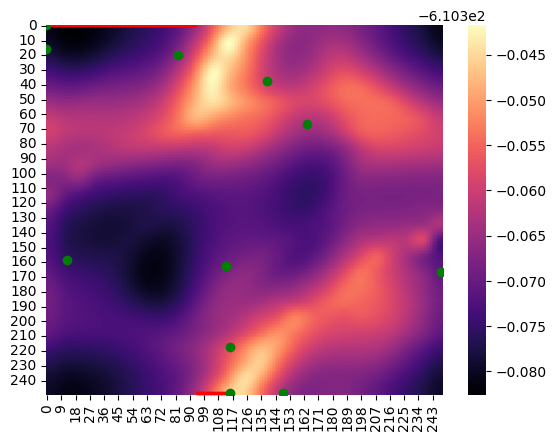

Total distance: 129.61017327339064
Start:  (99, 14)
Goal:  (156, 158)
Path:  [(100, 13), (101, 12), (102, 11), (103, 10), (103, 9), (103, 8), (103, 7), (103, 6), (103, 5), (103, 4), (103, 3), (103, 2), (103, 1), (103, 0), (104, 249), (105, 248), (106, 247), (107, 246), (107, 245), (107, 244), (107, 243), (107, 242), (107, 241), (107, 240), (107, 239), (107, 238), (107, 237), (107, 236), (107, 235), (107, 234), (107, 233), (107, 232), (107, 231), (107, 230), (107, 229), (107, 228), (107, 227), (107, 226), (107, 225), (107, 224), (107, 223), (107, 222), (107, 221), (107, 220), (107, 219), (107, 218), (107, 217), (107, 216), (107, 215), (107, 214), (107, 213), (107, 212), (107, 211), (107, 210), (107, 209), (107, 208), (108, 207), (108, 206), (109, 205), (110, 204), (111, 203), (112, 202), (113, 201), (114, 200), (115, 199), (116, 198), (117, 197), (118, 196), (119, 195), (120, 194), (121, 193), (122, 192), (123, 191), (124, 190), (125, 189), (126, 188), (127, 187), (128, 186), (129, 185)

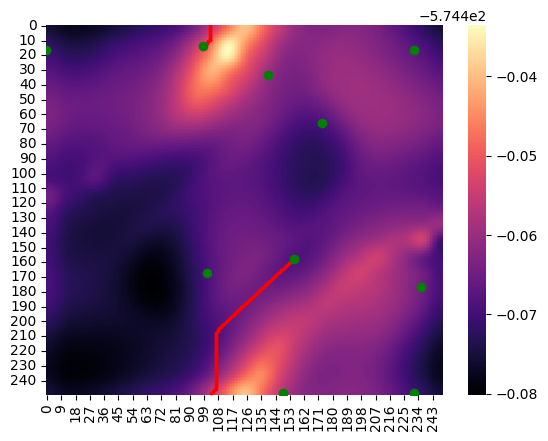

Total distance: 158.56349456037242
Start:  (11, 169)
Goal:  (121, 56)
Path:  [(12, 168), (13, 167), (14, 166), (15, 165), (16, 164), (17, 163), (18, 162), (19, 161), (20, 160), (21, 159), (22, 158), (23, 157), (24, 156), (25, 155), (26, 154), (27, 153), (28, 152), (29, 151), (30, 150), (31, 149), (32, 148), (33, 147), (34, 146), (35, 145), (36, 144), (37, 143), (38, 142), (39, 141), (40, 140), (41, 139), (42, 138), (43, 137), (44, 136), (45, 135), (46, 134), (47, 133), (48, 132), (49, 131), (50, 130), (51, 129), (52, 128), (53, 127), (54, 126), (55, 125), (56, 124), (57, 123), (58, 122), (59, 121), (60, 120), (61, 119), (62, 118), (63, 117), (64, 116), (65, 115), (66, 114), (67, 113), (68, 112), (69, 111), (70, 110), (71, 109), (72, 108), (73, 107), (74, 106), (75, 105), (76, 104), (77, 103), (78, 102), (79, 101), (80, 100), (81, 99), (82, 98), (83, 97), (84, 96), (85, 95), (86, 94), (87, 93), (88, 92), (89, 91), (90, 90), (91, 89), (92, 88), (93, 87), (94, 86), (95, 85), (96, 84), (97

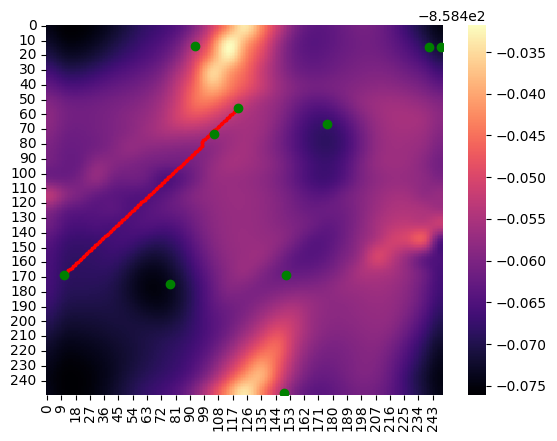

Total distance: 109.41421586850647
Start:  (9, 169)
Goal:  (150, 168)
Path:  [(8, 169), (7, 169), (6, 169), (5, 169), (4, 169), (3, 169), (2, 169), (1, 169), (0, 169), (249, 169), (248, 169), (247, 169), (246, 169), (245, 169), (244, 169), (243, 169), (242, 169), (241, 169), (240, 169), (239, 169), (238, 169), (237, 169), (236, 169), (235, 169), (234, 169), (233, 169), (232, 169), (231, 169), (230, 169), (229, 169), (228, 169), (227, 169), (226, 169), (225, 169), (224, 169), (223, 169), (222, 169), (221, 169), (220, 169), (219, 169), (218, 169), (217, 169), (216, 169), (215, 169), (214, 169), (213, 169), (212, 169), (211, 169), (210, 169), (209, 169), (208, 169), (207, 169), (206, 169), (205, 169), (204, 169), (203, 169), (202, 169), (201, 169), (200, 169), (199, 169), (198, 169), (197, 169), (196, 169), (195, 169), (194, 169), (193, 169), (192, 169), (191, 169), (190, 169), (189, 169), (188, 169), (187, 169), (186, 169), (185, 169), (184, 169), (183, 169), (182, 169), (181, 169), (180

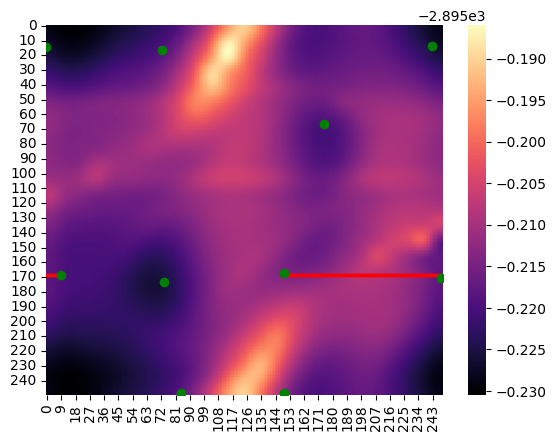

Total distance: 103.82339093457425
Start:  (78, 175)
Goal:  (150, 249)
Path:  [(79, 176), (80, 177), (81, 178), (82, 179), (83, 180), (84, 181), (85, 182), (86, 183), (87, 184), (88, 185), (89, 186), (90, 187), (91, 188), (92, 189), (93, 190), (94, 191), (95, 192), (96, 193), (97, 194), (98, 195), (99, 196), (100, 197), (101, 198), (102, 199), (103, 200), (104, 201), (105, 202), (106, 203), (106, 204), (106, 205), (107, 206), (108, 207), (109, 208), (110, 209), (111, 210), (112, 211), (113, 212), (114, 213), (115, 214), (116, 215), (117, 216), (118, 217), (119, 218), (120, 219), (121, 220), (122, 221), (123, 222), (124, 223), (125, 224), (126, 225), (127, 226), (128, 227), (129, 228), (130, 229), (131, 230), (132, 231), (133, 232), (134, 233), (135, 234), (136, 235), (137, 236), (138, 237), (139, 238), (140, 239), (141, 240), (142, 241), (143, 242), (144, 243), (145, 244), (146, 245), (147, 246), (148, 247), (149, 248), (150, 249)]
Local Minima:  (11, 169)
Local Minima:  (78, 175)
Loca

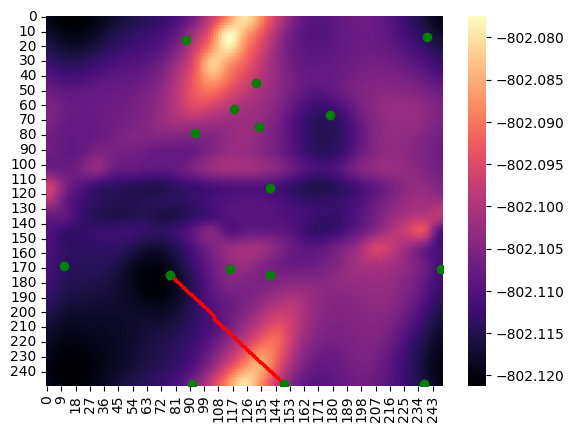

In [10]:
three_dim_matrices = csv_to_3D_matrix(folder_path=folder_path, csv_files=csv_files)
local_minima_per_matrix = [find_local_minima(i) for i in three_dim_matrices]
local_maxima_per_matrix = [find_local_maxima(i) for i in three_dim_matrices]

for i in range(len(three_dim_matrices)):
  # energy_levels = pd.read_csv(os.path.join(folder_path, csv_files[i]), header=None, names=['x', 'y', 'Value'])
  # heat_map = energy_levels.pivot(index='y', columns='x', values='Value')
  # sns.heatmap(heat_map, cmap='magma', annot=False, fmt=".1f")

  sns.heatmap(three_dim_matrices[i], cmap='magma', annot=False, fmt=".1f")
    
  # for k in local_minima_per_matrix[i]:
  #   for l in local_minima_per_matrix[i]:
  #     if k != l:
  #       path = a_star_wrap_around_surface(surface=three_dim_matrices[i], start=k, goal=l)
  #       print(path)

  #     # Separate the list into two lists: x-values and y-values
  #     x_values, y_values = zip(*path)

  #     # Create the scatter plot with a custom marker size
  #     plt.scatter(x_values, y_values, s=3, color='blue')

  start = local_minima_per_matrix[i][1]
  goal = local_minima_per_matrix[i][-5]
  path = a_star_wrap_around_surface(three_dim_matrices[i], start=start, goal=goal)
  print("Start: ", start)
  print("Goal: ", goal)
  print("Path: ", path)

  # Separate the list into two lists: x-values and y-values
  x_values, y_values = zip(*path)

  # Create the scatter plot with a custom marker size
  plt.scatter(x_values, y_values, s=3, color='red')
    
  for j in local_minima_per_matrix[i]:
    plt.scatter(x=j[0], y=j[1], color='green', marker='o')
    print("Local Minima: ", j)

  plt.show()
